In [46]:
# Sources
# https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html
# https://nbviewer.jupyter.org/github/OscarEngelbrektson/SyntheticControlMethods/blob/master/examples/user_guide.ipynb

In [47]:
import warnings
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import os 
from typing import List
from operator import add
from toolz import reduce, partial
from scipy import stats
from scipy.optimize import fmin_slsqp
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from matplotlib import style
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

# read data file
# pandas read_csv
dirs = os.getcwd() 
files = os.listdir(dirs) 

data = pd.read_excel(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/MSc/data/processed raw data_2.xlsx') 
data = data.loc[ (data.year < 2021) & (data.year >= 1965)]
raw_data = copy.deepcopy(data)# Copy dataframe



In [48]:
display(data)

,"Adolescent fertility rate (births per 1,000 women ages 15-19)","Agriculture, forestry, and fishing, value added (% of GDP)",Exports of goods and services (% of GDP),...,Urban population growth (annual %),country,year
5,119.256800,11.106980,22.603944,...,6.729878,Algeria,1965
6,117.134400,11.106980,25.986198,...,5.894366,Algeria,1966
7,115.012000,11.106980,23.434417,...,3.266680,Algeria,1967
8,112.681400,11.106980,23.135635,...,3.307126,Algeria,1968
9,110.350800,11.106980,23.788777,...,3.292629,Algeria,1969
...,...,...,...,...,...,...,...
4570,9.410331,1.587936,46.684512,...,0.479309,European Union,2016
4571,9.143510,1.693777,48.354594,...,0.430422,European Union,2017
4572,8.927777,1.609880,49.198138,...,0.445310,European Union,2018
4573,8.739422,1.591050,49.344668,...,0.359546,European Union,2019


In [49]:
print(data.columns)

Index(['Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Exports of goods and services (% of GDP)',
       'Fertility rate, total (births per woman)',
       'Foreign direct investment, net inflows (BoP, current US$)',
       'GDP (current US$)', 'GDP growth (annual %)',
       'Gross capital formation (% of GDP)',
       'Imports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Life expectancy at birth, total (years)',
       'Merchandise trade (% of GDP)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Population density (people per sq. km of land area)',
       'Population growth (annual %)', 'Population, total',
       'School enrollment, primary (% gross)', 'Surface area (sq. km)',
       'Urban population growth (annual %)', 'country', 'year'],
      dtype='object')

In [50]:
# make a list of countries 
lst_country =list(set(data.country))
print(sorted(lst_country))
print(len(lst_country))

['Algeria', 'Argentina', 'Australia', 'Bangladesh', 'Belize', 'Benin', 'Bolivia', 'Botswana', 'Brazil', 'Burkina Faso', 'Burundi', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Congo, Rep.', 'Costa Rica', 'Cote dIvoire', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Eswatini', 'European Union', 'Fiji', 'Gabon', 'Gambia, The', 'Ghana', 'Guatemala', 'Guyana', 'Honduras', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq', 'Jamaica', 'Kenya', 'Korea, Rep.', 'Lesotho', 'Madagascar', 'Malaysia', 'Mali', 'Mauritania', 'Mexico', 'Morocco', 'Nepal', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Rwanda', 'Senegal', 'Sierra Leone', 'Singapore', 'Sri Lanka', 'Sudan', 'Syrian Arab Republic', 'Thailand', 'Togo', 'Tunisia', 'Turkey', 'Uganda', 'Uruguay', 'Venezuela, RB', 'Zambia', 'Zimbabwe']
75


In [51]:
tmp = ''
for c in sorted(lst_country):
    tmp += " "+c + ','
print(tmp)
print(len(lst_country))

 Algeria, Argentina, Australia, Bangladesh, Belize, Benin, Bolivia, Botswana, Brazil, Burkina Faso, Burundi, Cameroon, Chad, Chile, China, Colombia, Congo, Rep., Costa Rica, Cote dIvoire, Dominican Republic, Ecuador, Egypt, Arab Rep., El Salvador, Eswatini, European Union, Fiji, Gabon, Gambia, The, Ghana, Guatemala, Guyana, Honduras, India, Indonesia, Iran, Islamic Rep., Iraq, Jamaica, Kenya, Korea, Rep., Lesotho, Madagascar, Malaysia, Mali, Mauritania, Mexico, Morocco, Nepal, New Zealand, Nicaragua, Niger, Nigeria, Norway, Oman, Pakistan, Panama, Papua New Guinea, Paraguay, Peru, Philippines, Rwanda, Senegal, Sierra Leone, Singapore, Sri Lanka, Sudan, Syrian Arab Republic, Thailand, Togo, Tunisia, Turkey, Uganda, Uruguay, Venezuela, RB, Zambia, Zimbabwe,
75


## Descriptive statistics

enter variables

In [52]:
incident = "QE"
incident_year = 2011
country = 'European Union'
variable = 'GDP growth (annual %)'

In [53]:
def descriptive_statistics(raw_data, country, incident_year, end_year):
        # Divide data by the year incident_year to check descriptive statistics
        all = raw_data.loc[raw_data.country == country ].describe()
        before = raw_data.loc[raw_data.year <= incident_year ].loc[raw_data.country == country ].describe()
        after = raw_data.loc[raw_data.year >  incident_year ].loc[raw_data.year <= end_year ].loc[raw_data.country == country ].describe()

        # export to excel file
        all.to_excel('before_after.xlsx')
        before.to_excel('before.xlsx')
        after.to_excel('after.xlsx')


        display(before
                [['GDP (current US$)', 'GDP growth (annual %)',
            'Exports of goods and services (% of GDP)',
            'Imports of goods and services (% of GDP)',
            'Foreign direct investment, net inflows (BoP, current US$)',
            'Inflation, GDP deflator (annual %)']])
        display(after
                [['GDP (current US$)', 'GDP growth (annual %)',
            'Exports of goods and services (% of GDP)',
            'Imports of goods and services (% of GDP)',
            'Foreign direct investment, net inflows (BoP, current US$)',
            'Inflation, GDP deflator (annual %)']])

In [54]:
descriptive_statistics(raw_data, country, incident_year, 2015)

,GDP (current US$),GDP growth (annual %),Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),"Foreign direct investment, net inflows (BoP, current US$)","Inflation, GDP deflator (annual %)"
count,4.700000e+01,47.000000,47.000000,47.000000,4.700000e+01,47.000000
mean,5.853537e+12,2.500146,27.805037,27.646739,1.990654e+11,5.652892
std,4.641860e+12,1.682336,6.921298,6.079922,3.227478e+11,3.176397
min,7.259311e+11,-4.348065,19.364094,19.687489,2.899569e+09,0.929441
25%,1.887477e+12,1.870006,23.178097,24.222370,7.712106e+09,3.254789
50%,5.084288e+12,2.652813,25.840240,26.444708,3.614308e+10,4.563179
75%,8.026812e+12,3.634559,33.131713,31.539593,2.944256e+11,7.110288
max,1.629763e+13,6.009138,43.214743,41.531607,1.477512e+12,13.355808


,GDP (current US$),GDP growth (annual %),Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),"Foreign direct investment, net inflows (BoP, current US$)","Inflation, GDP deflator (annual %)"
count,4.000000e+00,4.000000,4.000000,4.000000,4.000000e+00,4.000000
mean,1.478499e+13,0.786913,45.642035,42.006558,6.004422e+11,1.243586
std,9.236547e+11,1.395907,1.051721,0.531450,1.402052e+11,0.315529
min,1.355193e+13,-0.706732,44.803858,41.449658,4.307128e+11,0.982646
25%,1.436513e+13,-0.200678,44.924194,41.796124,5.487005e+11,1.022992
50%,1.496797e+13,0.771838,45.327268,41.923391,5.988103e+11,1.158214
75%,1.538782e+13,1.759428,46.045109,42.133825,6.505521e+11,1.378808
max,1.565210e+13,2.310708,47.109744,42.729792,7.734355e+11,1.675270


In [55]:
descriptive_statistics(raw_data, country, incident_year, 2020)

,GDP (current US$),GDP growth (annual %),Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),"Foreign direct investment, net inflows (BoP, current US$)","Inflation, GDP deflator (annual %)"
count,4.700000e+01,47.000000,47.000000,47.000000,4.700000e+01,47.000000
mean,5.853537e+12,2.500146,27.805037,27.646739,1.990654e+11,5.652892
std,4.641860e+12,1.682336,6.921298,6.079922,3.227478e+11,3.176397
min,7.259311e+11,-4.348065,19.364094,19.687489,2.899569e+09,0.929441
25%,1.887477e+12,1.870006,23.178097,24.222370,7.712106e+09,3.254789
50%,5.084288e+12,2.652813,25.840240,26.444708,3.614308e+10,4.563179
75%,8.026812e+12,3.634559,33.131713,31.539593,2.944256e+11,7.110288
max,1.629763e+13,6.009138,43.214743,41.531607,1.477512e+12,13.355808


,GDP (current US$),GDP growth (annual %),Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),"Foreign direct investment, net inflows (BoP, current US$)","Inflation, GDP deflator (annual %)"
count,9.000000e+00,9.000000,9.000000,9.000000,9.000000e+00,9.000000
mean,1.497319e+13,0.655120,46.977625,43.167253,4.568700e+11,1.456795
std,8.317773e+11,2.725984,1.698431,1.581332,2.662967e+11,0.459473
min,1.355193e+13,-5.955778,44.803858,41.449658,-3.415352e+10,0.874115
25%,1.463620e+13,-0.031993,45.690230,41.935169,2.960592e+11,1.036441
50%,1.529193e+13,1.816850,46.684512,42.729792,5.400017e+11,1.464064
75%,1.565210e+13,2.065499,48.354594,44.077874,6.095910e+11,1.675270
max,1.597821e+13,2.813595,49.344668,45.897118,7.734355e+11,2.199604


# 1. Raw data

In [56]:
data_gdp = data[
    ['year','country','GDP (current US$)','Imports of goods and services (% of GDP)','Exports of goods and services (% of GDP)',
      'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Fertility rate, total (births per woman)',
       'Foreign direct investment, net inflows (BoP, current US$)',
       'Industry (including construction), value added (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Life expectancy at birth, total (years)',
       'Merchandise trade (% of GDP)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Population density (people per sq. km of land area)',
       'Population, total',
       'School enrollment, primary (% gross)', 'Surface area (sq. km)',
       'Urban population growth (annual %)' ]]

data_gdp_growth = data[
    ['year','country','GDP growth (annual %)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Exports of goods and services (% of GDP)',
       'Fertility rate, total (births per woman)',
       'Foreign direct investment, net inflows (BoP, current US$)',
       'GDP (current US$)',
       'Gross capital formation (% of GDP)',
       'Imports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Life expectancy at birth, total (years)',
       'Merchandise trade (% of GDP)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Population density (people per sq. km of land area)',
        'Population, total',
       'School enrollment, primary (% gross)', 'Surface area (sq. km)',
       'Urban population growth (annual %)' ]]


data_inv = data[
    ['year','country','Gross capital formation (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Inflation, GDP deflator (annual %)',
       'Merchandise trade (% of GDP)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'School enrollment, primary (% gross)']]

data_fdi = data[
    ['year','country', 'Foreign direct investment, net inflows (BoP, current US$)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Exports of goods and services (% of GDP)',
       'Fertility rate, total (births per woman)',
       'GDP (current US$)', 'GDP growth (annual %)',
       'Imports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Life expectancy at birth, total (years)',
       'Merchandise trade (% of GDP)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Population density (people per sq. km of land area)',
        'Population, total',
       'School enrollment, primary (% gross)', 'Surface area (sq. km)',
       'Urban population growth (annual %)' ]]


data_export = data[
    ['year','country', 'Exports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Inflation, GDP deflator (annual %)',
       'Surface area (sq. km)',
       'Merchandise trade (% of GDP)',
       'Life expectancy at birth, total (years)',
       'School enrollment, primary (% gross)']]


data_import = data[
    ['year','country', 'Imports of goods and services (% of GDP)',
       'Industry (including construction), value added (% of GDP)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Inflation, GDP deflator (annual %)',
       'Surface area (sq. km)',
       'Merchandise trade (% of GDP)',
       'Life expectancy at birth, total (years)',
       'School enrollment, primary (% gross)']]
       



In [ ]:
agumented_synthetic_control_visualize(country ,'GDP growth (annual %)', data_gdp_growth , 2009, True)

In [57]:
def visulaize_origianl(country,interested_variable, data0):
  """
  Make graph with interested variable and country
  This function is to visulize the raw data 
  """

  # Make data0set that is only about entered country 
  str_expr = f"country == '{country}' " 
  data0_new = data0.query(str_expr) 
  plt.rc('font', family='serif')
  plt.rc('xtick', labelsize='x-small')
  plt.rc('ytick', labelsize='x-small')  
  plt.figure(figsize=(10,6)) 
  plt.plot(data0_new['year'], data0_new[interested_variable], label=interested_variable,color='black', lw=1)
  # plt.grid(False)
  # plt.ylabel(interested_variable)
  plt.legend();
 

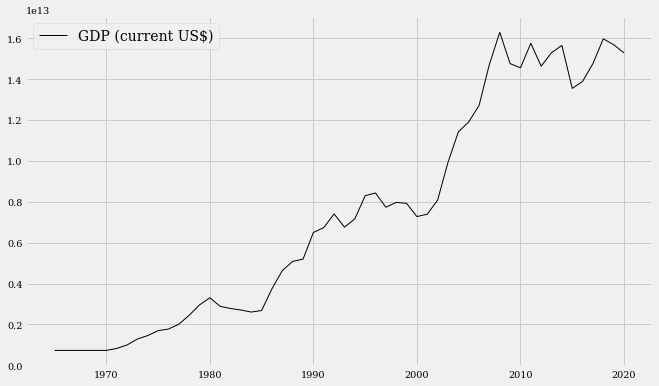

In [58]:
visulaize_origianl(country ,'GDP (current US$)', data_gdp_growth)

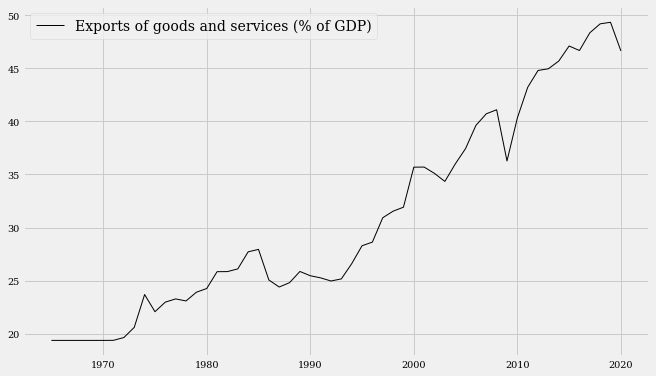

In [59]:
visulaize_origianl('European Union','Exports of goods and services (% of GDP)', data_export )

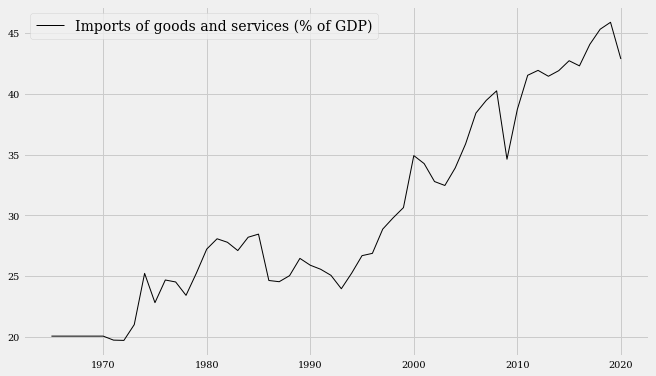

In [60]:
visulaize_origianl('European Union','Imports of goods and services (% of GDP)', data_import )

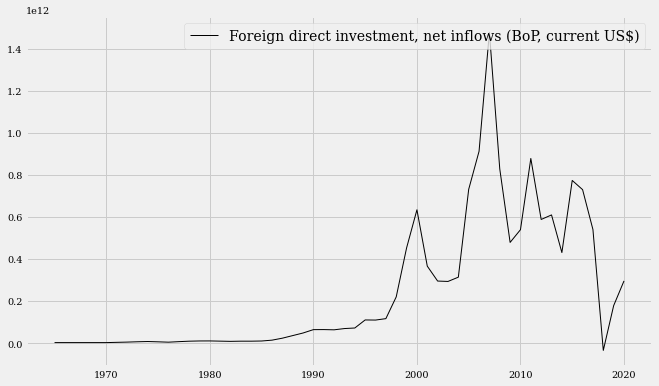

In [61]:
visulaize_origianl('European Union','Foreign direct investment, net inflows (BoP, current US$)', data_fdi )

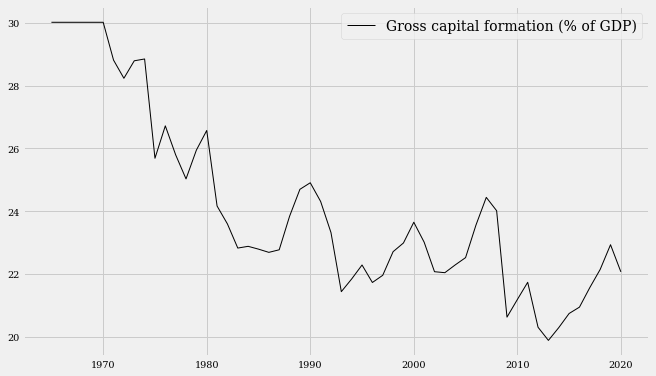

In [62]:
visulaize_origianl('European Union','Gross capital formation (% of GDP)', data_inv )


# 2. Synthetic Control Method

In [63]:
def X_y(country, main_variable, data0):
  """
   Get X and y
  """

  features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]

  #Make new dummy variable 'QE'
  data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values

  return X,y

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

def sythetic_weight(country, interested_variable, data0):   
  """
  Get the weight of synthetic control.
  """

  data_weights = get_w(X_y(country, interested_variable, data0)[0], X_y(country, interested_variable, data0)[1])
  
  print("Sum of weight:", data_weights.sum())
  print(data_weights)


  return np.round(data_weights, 4)

def synthetic_control(country, main_variable, data0):
  """
  This function is to generate the value of Synthetic Control

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  
  """

  #Make new dummy variable 'QE'
  data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year )]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
  inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the synthetic controls of countries in the pool or a given dataset
  weights_synth = sythetic_weight(country, main_variable, data0)
  weights_synth.round(3)

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_synth)

  data0_country['Synthetic'] = data_synth_lr

  return data0_country


def synthetic_control_dataframe(country, main_variable, data0):
 
  """
  This function is to make dataframe that contain the value of Synthetic Control

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  """

  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)

  # Make dataframe that contain values of augmented synthetic control
  data2 = synthetic_control(country, main_variable, data1)

  # Add column of difference
  data2[f'Difference'] = data2[main_variable]- data2['Synthetic']

  # Make dataframe that contain pre-treatment period only
  data_pre = data2.loc[data2.year <= incident_year]

  # Make dataframe that contain post-treatment period only
  data_post = data2.loc[data2.year > incident_year]

  # Calculate RMSPE for pre-treatment period only
  rmspe = rmse(data_pre[main_variable], data_pre['Synthetic'])
  print('Pre- RMSPE :', rmspe )

  # Calculate RMSPE for post-treatment period only
  rmspe = rmse(data_post[main_variable], data_post['Synthetic'])
  print('Post- RMSPE :', rmspe )

  return data2[['country','year',main_variable,'Synthetic','Difference']]

def synthetic_plot(country,main_variable, data0):
  """
  Show the plot of synthetic control
  """
  features = [main_variable]
  data_synth_1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[features].values.dot(sythetic_weight(country, main_variable, data0))
  plt.rc('font', family='serif')
  plt.rc('xtick', labelsize='x-small')
  plt.rc('ytick', labelsize='x-small')
  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[features], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_1, label="Synthetic Control",color='black')
  plt.ylabel(f"{main_variable} ")
  plt.legend();




## 3. Agumented Synthetic Control Method

In [64]:

def agumented_synthetic_control(country, main_variable, data0, std_scaling=True):
  """
  This function is to make dataframe that contain the value of ASCM

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  
  """
    #standard scaling for control variables
  if std_scaling:
    features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
    data0[features] = StandardScaler().fit_transform(data0[features])
  

  #Make new dummy variable 'QE'
  data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
  inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  weights_ridge.round(3)

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)

  data0_country['ASCM'] = data_synth_lr

  return data0_country

def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

def agumented_synthetic_control_dataframe(country, main_variable, data0, incident_year):

  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)

  # Make dataframe that contain values of augmented synthetic control
  data2 = agumented_synthetic_control(country, main_variable, data1)

  # Add column of difference
  data2['Difference'] = data2[main_variable]- data2['ASCM']

  # Make dataframe that contain pre-treatment period only
  data_pre = data2.loc[data2.year <= incident_year ]

  # Make dataframe that contain post-treatment period only
  data_post = data2.loc[data2.year > incident_year ]

  # Calculate RMSPE for pre-treatment period only
  rmspe = rmse(data_pre[main_variable], data_pre['ASCM'])
  print('Pre- RMSPE :', rmspe )

  # Calculate RMSPE for post-treatment period only
  rmspe = rmse(data_post[main_variable], data_post['ASCM'])
  print('Post- RMSPE :', rmspe )

  return data2[['country','year',main_variable,'ASCM','Difference']]


# Country : The country you want to see
# main_variable: Variable you want to see. ex) CA
# data0 : data that you have

def agumented_weight_visualize(country, main_variable, data0):
  """
  This function is for showing the weight of countries from ridge ASMC

  # Country : The country you want to see
  # main_variable: Variable you want to see. ex) CA
  # data0 : data that you have
  
  """

  #Make new dummy variable 'QE'
  data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
  inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  weights_ridge_rounded = weights_ridge.round(3)

  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  dic = {}
  for index in range(len(pool)-1):
    dic[pool[index]] = weights_ridge_rounded[index]
  return dic



# Country : The country you want to see
# pool: list of country in data set
# main_variable: Variable you want to see. ex) CA
# data0 : data that you have

def agumented_synthetic_control_visualize(country, main_variable, data0, incident_year=2011, std_scaling=True):

  #standard scaling for control variables
  if std_scaling:
    features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
    data0[features] = StandardScaler().fit_transform(data0[features])
  
  #Make new dummy variable 'QE'
  data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
  inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  
  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]
  
  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)

  # interest variable data with interested country only
  data_2 = data0.query(f"country == '{country}'")[main_variable]
  plt.rc('font', family='serif')
  plt.rc('xtick', labelsize='x-small')
  plt.rc('ytick', labelsize='x-small')
  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data_2, label=f"{country}",color='dimgray', linestyle=":", lw=1)
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label="Augmented Synthetic Control",color='black', lw=1)


  val_max = max(data_synth_lr.max(),data_2.max())
  val_min = min(data_synth_lr.min(),data_2.min())
  
  plt.grid(False)
  plt.vlines(x=incident_year , ymin= val_min, ymax=val_max , linestyle=":", lw=2, label="QE")
  plt.ylabel(f"{main_variable}")
  plt.legend();



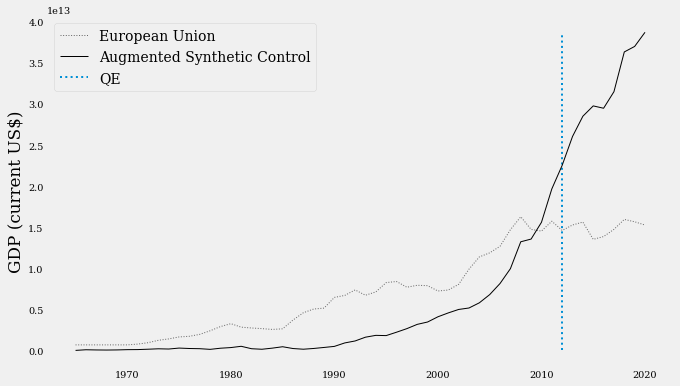

In [65]:
agumented_synthetic_control_visualize(country ,'GDP (current US$)', data_gdp, 2012, True)

In [ ]:
data_gdp_growth = data[
    ['year','country','GDP growth (annual %)',

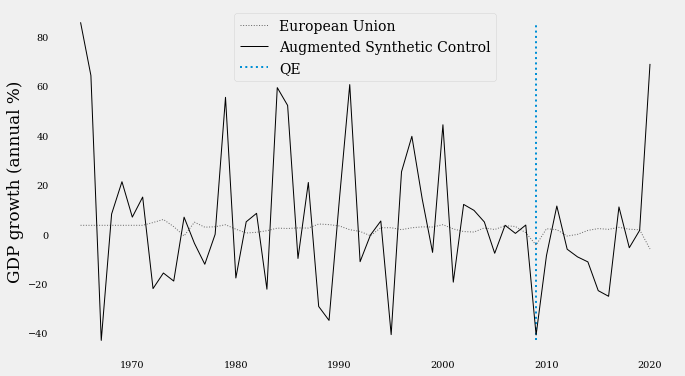

In [90]:
agumented_synthetic_control_visualize(country ,'GDP growth (annual %)', data_gdp_growth , 2009, True)

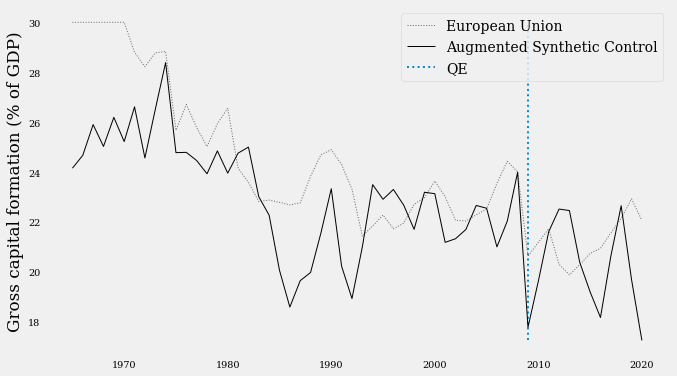

In [67]:
agumented_synthetic_control_visualize(country ,'Gross capital formation (% of GDP)', data_inv , 2009, True)

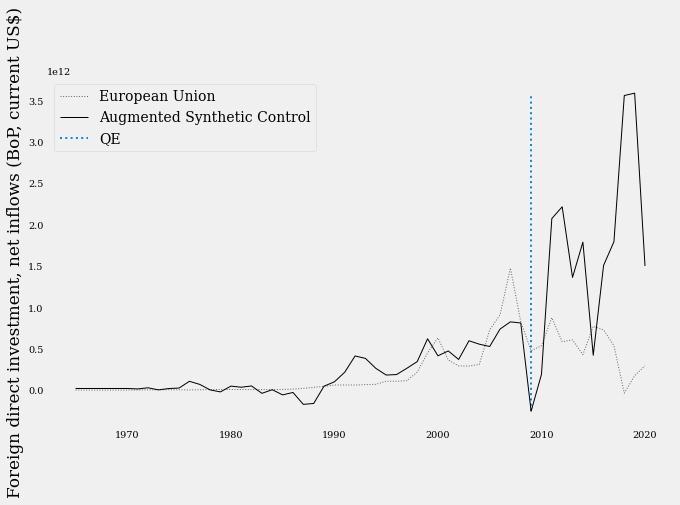

In [68]:
agumented_synthetic_control_visualize(country ,'Foreign direct investment, net inflows (BoP, current US$)', data_fdi, 2009, False)

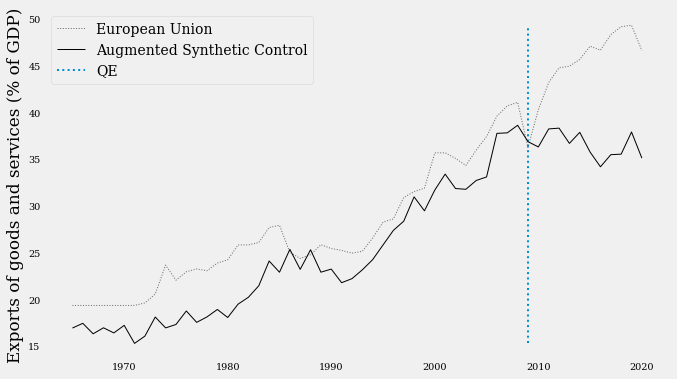

In [69]:
agumented_synthetic_control_visualize('European Union','Exports of goods and services (% of GDP)', data_export, 2009,True )

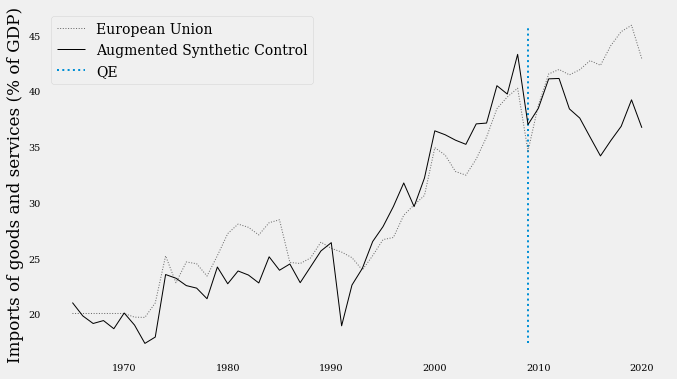

In [70]:
agumented_synthetic_control_visualize(country ,'Imports of goods and services (% of GDP)', data_import, 2009,True)

## 4. Robust analysis

In [71]:
def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

def rmspe_table(country, main_variable, data0, incident_year=2011, outlier = 0):
  print('*'*300)
  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)
  
  # Make list that contain names of countries
  pool = list(data1['country'].unique())
  
  # find the first country of this dataset 
  first_country = list(data0['country'])[0]

  # check the number of data for first country
  first_country_data_number = data0.loc[data0['country'] == first_country].shape[0]


  # make empty list to store values
  country_lst = []
  rmspe_ratio_lst = []
  country_ratio = []

  for each_country in pool:

    str_expr = f"country == '{each_country}' " 
    data0_new = data0.query(str_expr) 

    # here we will check whether the number of data for other countries would be the same
    # not all countries have the smae number of yearly data
    if first_country_data_number == data0_new.shape[0]:

      # Make dataframe that contain values of augmented synthetic control
      data2 = agumented_synthetic_control(each_country, main_variable, data1, True)

      # Add column of difference
      data2['Difference'] = data2[main_variable]- data2['ASCM']

      # Make dataframe that contain pre-treatment period only
      data_pre = data2.loc[data2.year <= incident_year ]

      # Make dataframe that contain post-treatment period only
      data_post = data2.loc[data2.year > incident_year ]

      print('*'*300)
      print('<',each_country,'>')
      print('')

      # Calculate RMSPE for pre-treatment period only
      rmspe_pre = rmse(data_pre[main_variable], data_pre['ASCM'])
      print(f'Pre- RMSPE :', rmspe_pre )
      print('')
      
      # Calculate RMSPE for post-treatment period only
      rmspe_post = rmse(data_post[main_variable], data_post['ASCM'])
      print(f'Post- RMSPE :', rmspe_post )
      print('')
      print('Ratio Post_RMSPE/Pre_RMSPE : ',rmspe_post/rmspe_pre )
      print('')
      print('*'*300)

      # append results to lists for plotting
      country_ratio.append([each_country,rmspe_post/rmspe_pre])
      
  # sort rmspe_ratio based on values
  country_ratio.sort(key = lambda x: x[1])
  
  # delete outliers
  country_ratio2 = country_ratio[0:len(country_ratio)-outlier]


  # make a list of deleted countries
  deleted_country = []

  # append deleted country to an empty list
  if outlier !=0:
    for i in range(outlier):
      deleted_country.append(country_ratio[len(country_ratio)-1-(i+1)][0])
  
  country_lst = [ country for country, ratio in country_ratio2] # list that contain country name
  rmspe_ratio_lst = [ ratio for country, ratio in country_ratio2] # list that contain rmspe ratio
  country_lst_np = np.array(country_lst)
  rmspe_ratio_lst_np = np.array(rmspe_ratio_lst)

  plt.rc('font', family='serif')
  plt.rc('xtick', labelsize='x-small')
  plt.rc('ytick', labelsize='x-small')  
  plt.figure(figsize=(10,6)) 
  col = np.where(country_lst_np == country,'r' , np.where(country_lst_np=='p','k','black')) # set conditions of color  
  plt.scatter(country_lst_np, rmspe_ratio_lst_np, c= col , label='rmspe_post/rmspe_pre')
  plt.xticks(rotation=90)
  plt.ylabel(main_variable)
  plt.legend();

  

def placebo_visualize(interested_country, interested_variable, data0, incident_year=2011, std_scaling=True):

  # standard scaling for control variables
  if std_scaling:
    features = [feature for feature in data0.columns if feature not in ['country', 'year', interested_variable]]
    data0[features] = StandardScaler().fit_transform(data0[features])

  # Make a list of country in a dataset
  pool = list(data0['country'].unique())
  
  # find the first country of this dataset 
  first_country = list(data0['country'])[0]

  # check the number of data for first country
  first_country_data_number = data0.loc[data0['country'] == first_country].shape[0]

  synth_list = []
  for country in pool:
    str_expr = f"country == '{country}' " 
    data0_new = data0.query(str_expr) 
    
    if first_country_data_number == data0_new.shape[0]:
      # Make temporary dataframe that contains synthetic values
      temp_dataframe = agumented_synthetic_control(country, interested_variable, data0)
      synth_list.append(temp_dataframe)
  
  # Make gahtered data
  data_synth_all= pd.concat(synth_list, axis = 0, sort= False)

  # Make a plot for all country except interested_country
  plt.figure(figsize=(10,6))
  plt.plot(data_synth_all['year'],data_synth_all[f'{interested_variable}']-data_synth_all['ASCM'],alpha=.6, label = 'placebo effect',color='dimgray', linestyle=":", lw=1) 
  
  # Make a plot for interested country
  temp_dataframe2 = agumented_synthetic_control(interested_country, interested_variable, data0)
  
  plt.plot(temp_dataframe2['year'],temp_dataframe2[f'{interested_variable}']-temp_dataframe2['ASCM'], alpha=.6, label = f'QE impact on {interested_country}',color='black', lw=1.5)
  plt.rc('font', family='serif')
  plt.rc('xtick', labelsize='x-small')
  plt.rc('ytick', labelsize='x-small')
  plt.grid(False)
  plt.ylabel(f"{interested_variable}")
  plt.legend();  
  plt.show()

def p_value_analysis(interested_country, interested_variable, data0, incident_year = 2011):
  """
  Note
  Treatment effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the interested country)
  Placebo effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the all the other country except the main country)

  P-value is calculated with following two steps 
  - 1st step : Count the number of placebo effects that have larger absolute values than those of treatment effects.
  - 2nd step : Divide the value from 1st step by the total number of countries 
  """

  # Make list that contains sum of absolute placebo effect value
  placebo_all_year = []

  # Make list that contains sum of absolute treatment effect value
  treatment_all_year = []

  # Make a list of country in a dataset
  pool = list(data0['country'].unique())
  
  # Make list of year in a dataframe
  pool_year = list(data0['year'].unique())
  current_year = incident_year
  
  # find the first country of this dataset 
  first_country = list(data0['country'])[0]

  # check the number of data for first country
  first_country_data_number = data0.loc[data0['country'] == first_country].shape[0]

  # make empty lists for plotting
  lst_year =[]
  lst_p_value = []  

  for year in range(-9,0):# year is -13,-12,-11 ... This is to select ASCM from 2008 to 2021
    synth_list = []
    current_year += 1

    for country in pool:
      str_expr = f"country == '{country}' " 
      data0_new = data0.query(str_expr) 

      if first_country_data_number == data0_new.shape[0]:      
        # Make temporary dataframe that contains synthetic values
        temp_dataframe = agumented_synthetic_control(country, interested_variable, data0)
        
        # print(temp_dataframe)
        value_agumented_synthetic_control  = temp_dataframe.iloc[year,-1] # (left: row), (right:column)
        value_interested_variable  = temp_dataframe.iloc[year,2]

        # print(value_interested_variable, value_synthetic_control)
        placebo_effect = value_interested_variable - value_agumented_synthetic_control
        synth_list.append(placebo_effect)

    # Calculate synthetic value for interested country in 2020 year
    synth_interested_country = agumented_synthetic_control(interested_country, interested_variable, data0)

    value_agumented_synthetic_control_main_country = synth_interested_country.iloc[year,-1]
    value_interested_variable_main_country = synth_interested_country.iloc[year,2]

    treatment_effect = value_interested_variable_main_country - value_agumented_synthetic_control_main_country

    treatment_all_year.append(abs(treatment_effect))
    # Make dictionray to summarise placebo effect
    
    placebo_effect_dictionary = {}
    for now_country, placebo_value in zip(pool[0:-1],synth_list[0:-1]):
      placebo_effect_dictionary[now_country] = placebo_value
    print('Placebo effects:',placebo_effect_dictionary )

    # Make a new list that contains placebo effects which are larger than the treatment effect
    sorted_list= [placebo_effect for placebo_effect in synth_list if abs(placebo_effect) > abs(treatment_effect)]

    p_value = len(sorted_list)/(len(synth_list)-1) # -1: exclude the interested country in the list

    # Print treament effect
    print(f'QE Treatment Effect for the Year {current_year} ({interested_country}): {treatment_effect}')
    print(f'p-value : {p_value}')
    print('')
    print('')
 
    # append results to lists for plotting
    lst_year.append(current_year)
    lst_p_value.append(p_value)


  plt.rc('font', family='serif')
  plt.rc('xtick', labelsize='x-small')
  plt.rc('ytick', labelsize='x-small')  
  plt.figure(figsize=(10,6)) 
  plt.scatter(lst_year, lst_p_value, label='p_value')
  plt.ylabel(interested_variable)
  plt.legend();



def agumented_synthetic_control_visualize_limit_donor_pool(country, main_variable, data0, incident_year=2011, std_scaling=True):

  # standard scaling for control variables
  if std_scaling:
    features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
    data0[features] = StandardScaler().fit_transform(data0[features])

    country_list  = list(data0['country'].unique())
    count = 1
    while len(country_list) > 1 :
        data0 = data0.loc[data0.country.isin(country_list) == True]
        
        #Make new dummy variable 'QE'
        print('')
        print('Countries:', country_list[0:-1])
        data0['QE'] = [1 if t else 0 for t in list(data0['year'] > incident_year)]

        # make data only about selected country
        str_expr = f"country == '{country}' "   
        data0_country = data0.query(str_expr) 

        # .T  flip the table to have one column per state
        features = [feature for feature in data0.columns if feature not in ['country', 'year', main_variable]]
        inverted = data0.query("QE == 0").pivot(index='country', columns="year")[features].T
        
        # Replace the missing value
        inverted = inverted.fillna(method='pad')
        
        # Set X and y
        y = inverted[country].values
        X = inverted.drop(columns= country).values
        
        # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
        weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
        print('Weights:', weights_ridge)
        # Show weight of countries in the pool
        pool = list(data0['country'].unique())

        #select countries without country and make tables about main variable entered
        data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

        # multiply values of main variable with weight that we have gotten
        data_synth_lr = data1.values.dot(weights_ridge)
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize='x-small')
        plt.rc('ytick', labelsize='x-small')
        plt.figure(figsize=(10,6))
        plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}", color='dimgray', linestyle=":", lw=1, alpha=.6 )
        plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label=f"ASCM exclude {count} / {country_list[0]}", color='black', lw=1)
        plt.title(f"{main_variable}")
        plt.legend();
        plt.grid(False)
        plt.savefig(f'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/MSc/ascm/image/{main_variable}_{count}.png')
        country_list.pop(0)
        count += 1




In [72]:
agumented_synthetic_control_dataframe('European Union','GDP (current US$)', data_gdp, 2010).to_excel('gdp rmspe.xlsx')

Pre- RMSPE : 0.7512061654756089
Post- RMSPE : 1.1350903356121291


In [73]:
agumented_synthetic_control_dataframe('European Union','Imports of goods and services (% of GDP)', data_import, 2011).to_excel('import rmspe.xlsx')

Pre- RMSPE : 0.09064268721790275
Post- RMSPE : 0.12208417917372344


In [74]:
agumented_synthetic_control_dataframe('European Union','Exports of goods and services (% of GDP)', data_export, 2011).to_excel('export rmspe.xlsx')

Pre- RMSPE : 0.10974231025875116
Post- RMSPE : 0.18468021259501932


In [75]:
agumented_synthetic_control_dataframe('European Union','Foreign direct investment, net inflows (BoP, current US$)', data_fdi, 2011).to_excel('fdi rmspe.xlsx')

Pre- RMSPE : 0.7454773642924464
Post- RMSPE : 3.006311195828826


In [76]:
agumented_synthetic_control_dataframe('European Union','Gross capital formation (% of GDP)', data_inv, 2011).to_excel('gross capital rmspe.xlsx')

Pre- RMSPE : 0.09311834170817683
Post- RMSPE : 0.10815987039784233


************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
< Algeria >

Pre- RMSPE : 1.197887527796689

Post- RMSPE : 2.638861329274042

Ratio Post_RMSPE/Pre_RMSPE :  2.202929129855605

*******************************************************************************************************************************************************************************************************************************************************************************

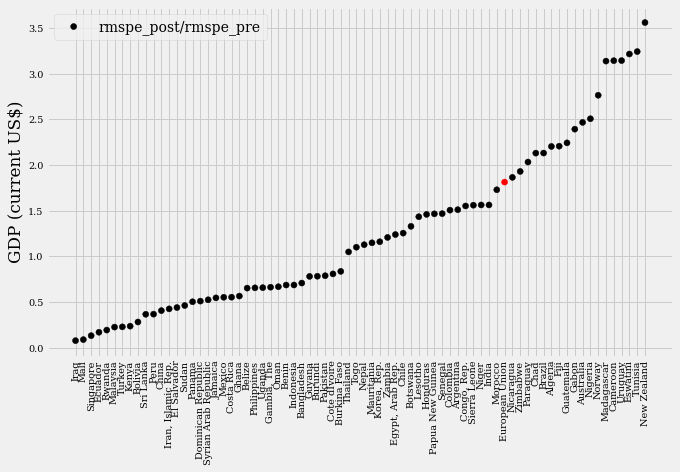

In [77]:
rmspe_table('European Union','GDP (current US$)', data_gdp, 2015, 1)

************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
< Algeria >

Pre- RMSPE : 0.5417940716966366

Post- RMSPE : 0.4241866115455427

Ratio Post_RMSPE/Pre_RMSPE :  0.7829295920813524

****************************************************************************************************************************************************************************************************************************************************************************

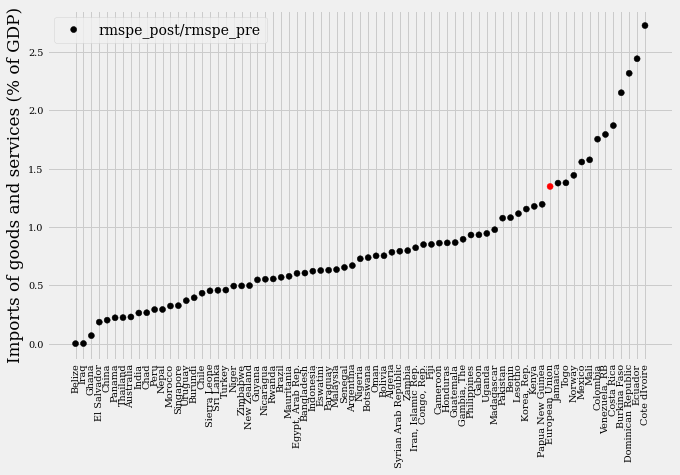

In [78]:
rmspe_table('European Union','Imports of goods and services (% of GDP)', data_import, 2011, 2)

************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
< Algeria >

Pre- RMSPE : 0.5760614293858781

Post- RMSPE : 0.7459301248158385

Ratio Post_RMSPE/Pre_RMSPE :  1.294879481188408

*****************************************************************************************************************************************************************************************************************************************************************************

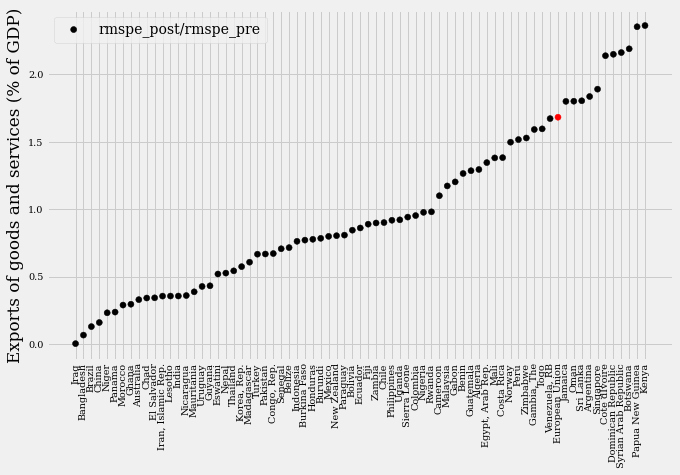

In [79]:
rmspe_table('European Union','Exports of goods and services (% of GDP)', data_export, 2011, 2)

************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
< Algeria >

Pre- RMSPE : 1159782.6312460785

Post- RMSPE : 24.57944695972506

Ratio Post_RMSPE/Pre_RMSPE :  2.1193149731270533e-05

*************************************************************************************************************************************************************************************************************************************************************************

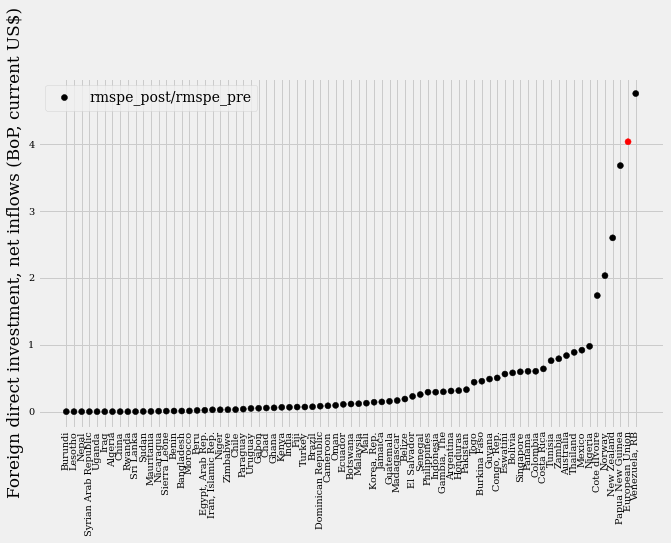

In [80]:
rmspe_table('European Union','Foreign direct investment, net inflows (BoP, current US$)', data_fdi, 2011, 0)

************************************************************************************************************************************************************************************************************************************************************************************************************
************************************************************************************************************************************************************************************************************************************************************************************************************
< Algeria >

Pre- RMSPE : 0.20131311223370366

Post- RMSPE : 0.31252819929501385

Ratio Post_RMSPE/Pre_RMSPE :  1.552448302186104

***************************************************************************************************************************************************************************************************************************************************************************

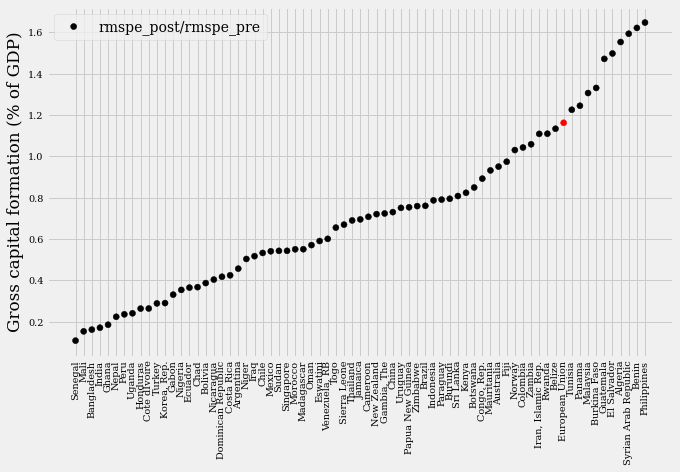

In [81]:
rmspe_table('European Union','Gross capital formation (% of GDP)', data_inv, 2011, 4)

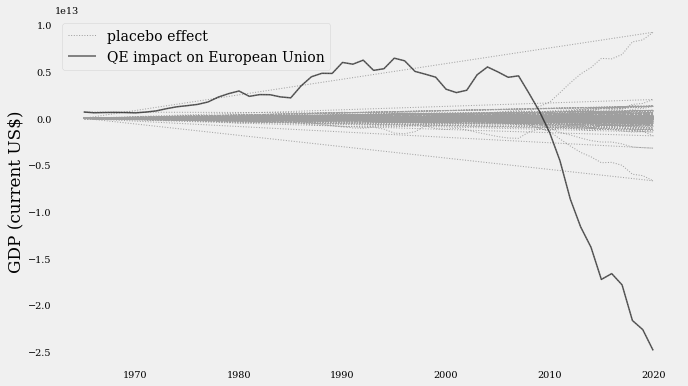

In [82]:
placebo_visualize(country ,'GDP (current US$)', data_gdp, 2011, True)

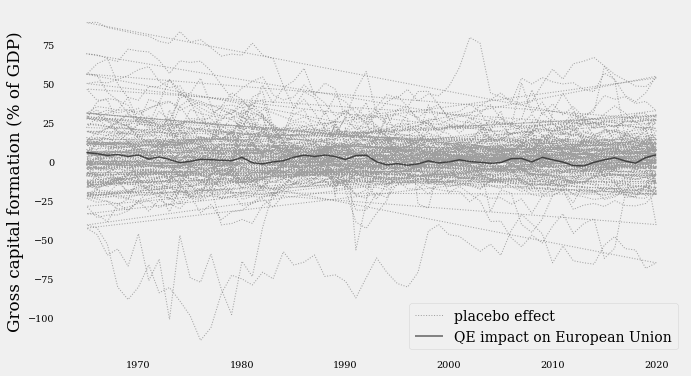

In [83]:
placebo_visualize(country ,'Gross capital formation (% of GDP)', data_inv, 2011, True)

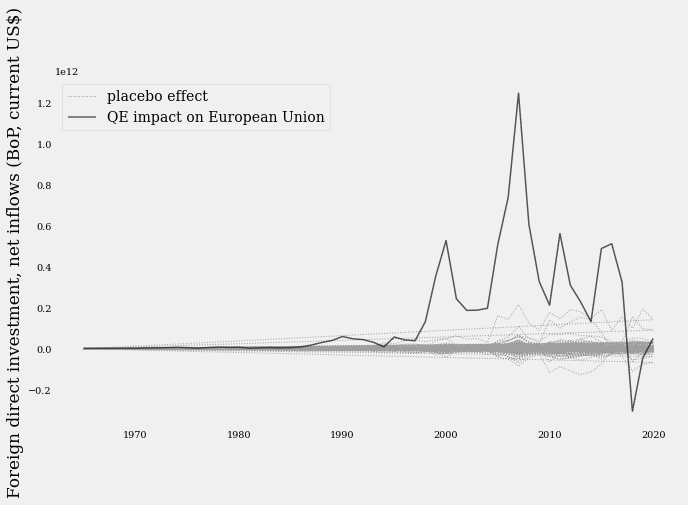

In [84]:
placebo_visualize(country ,'Foreign direct investment, net inflows (BoP, current US$)', data_fdi, 2011, True)

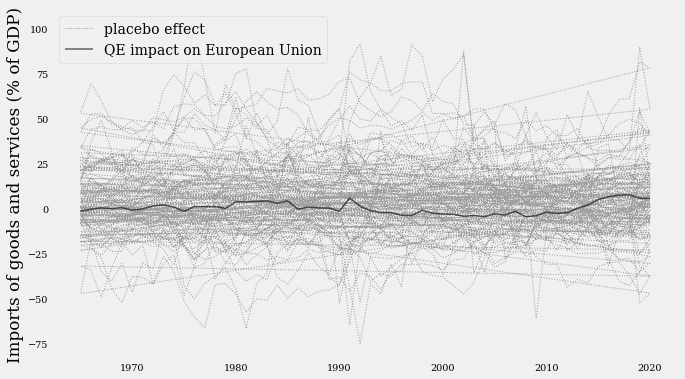

In [85]:
placebo_visualize(country ,'Imports of goods and services (% of GDP)', data_import, 2011,True)

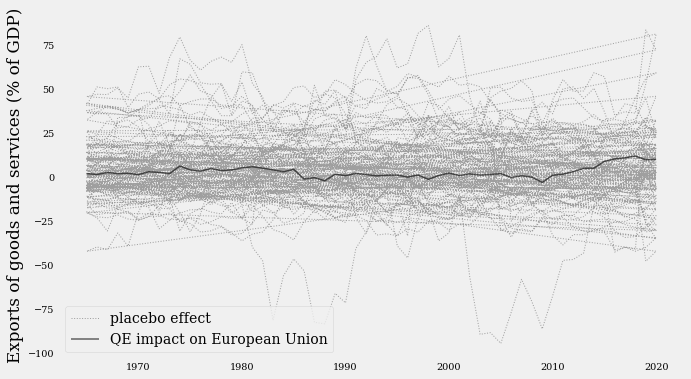

In [86]:
placebo_visualize(country ,'Exports of goods and services (% of GDP)', data_export, 2011,True )

Placebo effects: {'Algeria': -430819581482.197, 'Argentina': 43368755648.966736, 'Australia': -1781959638295.725, 'Bangladesh': 385312220969.4544, 'Belize': 430824386993.2845, 'Benin': 245325196093.12558, 'Bolivia': -128821765501.45937, 'Botswana': -1084670909455.9333, 'Brazil': 21173796352.12549, 'Burkina Faso': 80750461946.18233, 'Burundi': 152337967289.77933, 'Cameroon': 308964502765.6507, 'Chad': 400926841731.7931, 'Chile': -464178213978.9508, 'China': 3800758819128.1064, 'Colombia': -133290430684.83191, 'Congo, Rep.': -305120461921.04645, 'Costa Rica': -117174581783.34497, 'Cote dIvoire': 36981800571.04459, 'Dominican Republic': -321616034376.1003, 'Ecuador': -154733452197.81946, 'Egypt, Arab Rep.': 126067990030.9852, 'El Salvador': -213865763139.74948, 'Eswatini': 663264228306.3927, 'Fiji': 148096859696.84042, 'Gabon': -41273204675.72165, 'Gambia, The': 32680819468.2783, 'Ghana': -221517491233.26074, 'Guatemala': 291740091056.4428, 'Guyana': 817124762223.4738, 'Honduras': 1750703

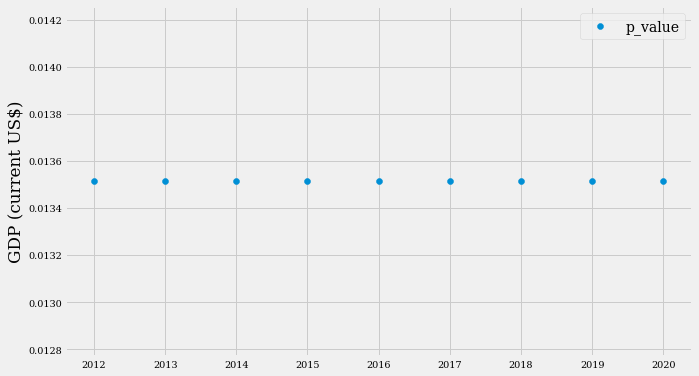

In [87]:
p_value_analysis(country ,'GDP (current US$)', data_gdp)

Placebo effects: {'Algeria': 8.605881969676133, 'Argentina': -1.4768116757852994, 'Australia': 9.347521442127523, 'Bangladesh': -5.099833986111104, 'Belize': 3.239517135597721, 'Benin': 7.09619139753444, 'Bolivia': 4.826055243677963, 'Botswana': 35.169437767862455, 'Brazil': 20.302861702551652, 'Burkina Faso': 9.314395648245528, 'Burundi': -12.876166831077654, 'Cameroon': -13.653174200737979, 'Chad': 62.59370723493701, 'Chile': 7.626250559954805, 'China': 16.140923184329996, 'Colombia': -13.25659019148118, 'Congo, Rep.': 27.144408186577426, 'Costa Rica': 0.7934756340044764, 'Cote dIvoire': 6.101690764701457, 'Dominican Republic': 3.5921634177774884, 'Ecuador': -2.467296747674414, 'Egypt, Arab Rep.': -21.279631176610177, 'El Salvador': -15.530110296794703, 'Eswatini': 6.922565565028508, 'Fiji': 16.767172038227503, 'Gabon': -0.5002989841766983, 'Gambia, The': 25.406838584374547, 'Ghana': -14.369590806457797, 'Guatemala': -20.650897295761382, 'Guyana': 50.44170779803086, 'Honduras': 1.156

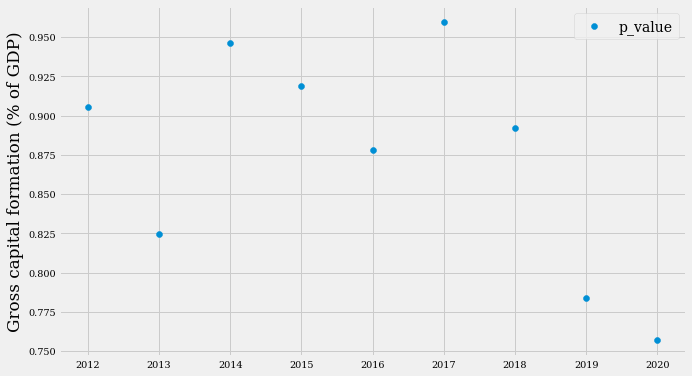

In [88]:
p_value_analysis(country ,'Gross capital formation (% of GDP)', data_inv )

In [89]:
p_value_analysis(country ,'Foreign direct investment, net inflows (BoP, current US$)', data_fdi)

Placebo effects: {'Algeria': -35856169034.81527, 'Argentina': -10730483898.082615, 'Australia': -41938863186.38829, 'Bangladesh': 20777479082.324482, 'Belize': 4674816664.0161085, 'Benin': 20860867527.03213, 'Bolivia': 17388897087.866615, 'Botswana': 17328347606.044003, 'Brazil': 7611862587.460037, 'Burkina Faso': 17856084117.092987, 'Burundi': -19830742484.282345, 'Cameroon': 14587283352.228678, 'Chad': 27383688584.867123, 'Chile': 28207121148.20575, 'China': 131249855432.89793, 'Colombia': 8306664972.017005, 'Congo, Rep.': -14998881157.971874, 'Costa Rica': -9643977227.23163, 'Cote dIvoire': 7370987005.653768, 'Dominican Republic': 10237136622.940939, 'Ecuador': 5846943258.067368, 'Egypt, Arab Rep.': -13042872621.422543, 'El Salvador': 11224315539.591438, 'Eswatini': 1207086811.2646275, 'Fiji': 16261999660.849045, 'Gabon': -4130413874.7540007, 'Gambia, The': 10462556939.304726, 'Ghana': 1581212052.1241336, 'Guatemala': -4256634286.751314, 'Guyana': -40989052242.34318, 'Honduras': -10

KeyboardInterrupt: 

In [ ]:
p_value_analysis(country  ,'Imports of goods and services (% of GDP)', data_import)

Placebo effects: {'Algeria': -16.858926812202874, 'Argentina': -0.09453581654970833, 'Australia': 9.261778606845107, 'Bangladesh': -6.389533570874271, 'Belize': -1.6395910197399886, 'Benin': 12.636149222107997, 'Bolivia': 27.896492373055302, 'Botswana': 28.343383986000504, 'Brazil': 35.23675876430032, 'Burkina Faso': 12.469592990288142, 'Burundi': -1.7162603090629531, 'Cameroon': -0.20909959113820875, 'Chad': 11.380486289980215, 'Chile': 3.3167602905086113, 'China': -2.791490250490938, 'Colombia': 0.05792588517158492, 'Congo, Rep.': -7.949471495973157, 'Costa Rica': -21.802879672168892, 'Cote dIvoire': 16.19986389928801, 'Dominican Republic': -7.819897336859427, 'Ecuador': -8.316038459509631, 'Egypt, Arab Rep.': -3.2533798548352557, 'El Salvador': -0.7452690275879874, 'Eswatini': 0.5963971923351323, 'Fiji': 40.56862184542322, 'Gabon': 11.57970920204551, 'Gambia, The': 11.356777576576636, 'Ghana': 12.893677017291395, 'Guatemala': -16.882510406147574, 'Guyana': 3.738539663532652, 'Hondur

KeyboardInterrupt: 

In [ ]:
p_value_analysis(country ,'Exports of goods and services (% of GDP)', data_export)

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool(country,'GDP (current US$)', data_gdp , 2011, True)

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool(country,'Gross capital formation (% of GDP)', data_inv , 2011, True)

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool(country,'Foreign direct investment, net inflows (BoP, current US$)', data_fdi ,2011,True )

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool(country,'Exports of goods and services (% of GDP)', data_export,2011,True )

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool(country ,'Imports of goods and services (% of GDP)', data_import, 2011,True)